<a href="https://colab.research.google.com/github/Braafisch/Motion-Planning-Assignment/blob/main/Assignment_1/MP_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motion Planning, Assignment 1: Bug Algorithms

In this assignment, you will implement the Bug1 algorithm and test it in simulation. The assignment is divided into several excercises (with increasing level of difficulty) which are supposed to guide you towards the final implementation. If you haven't used Python before, check out the Python information on the course's Moodle page. 

The robot in this simulation is a point-shaped robot equipped with a laser scanner (cf. [Fig. 1](#fig_1)). Its position is given by $(x, y, \theta)$. The entities $x, y,$ and  $\theta$ are given in **global** coordinates.

As can be seen in [Fig. 1](#fig_1), the sensor readings are given with respect to an angle $\varphi$ in **local** coordinates. This means, that $\varphi$ is given **relative** to the robots orientation $\theta$.

<a id="fig_1"></a>
![Fig. 1: Robot scenario](https://drive.google.com/uc?export=view&id=11Ai2mL8tMdjGK6Sz7pXx-5d0pCXJ_jQO)

First, load upload necessary library files to Colab:

In [3]:
import requests
import io
import shutil

url = 'https://raw.githubusercontent.com/Braafisch/Motion-Planning-Assignment/main/Assignment_1/bugsim.py'
response = requests.get(url, allow_redirects = True)

with open('bugsim.py', 'wb') as fin:
    shutil.copyfileobj(io.BytesIO(response.content), fin)

Now, load the necessary libraries:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

from bugsim import BugSim, normalizeAngle

## Exercise 1.1: Introduction

To get a first impression of the robot simulator, check out how a sample scenario is created. 

The following code section defines obstacles as set of axis-aligned rectangles. These ``objects`` are given as a list of points ``[xmin, ymin, xmax, ymax]`` where (xmin, ymin) denotes the lower left and (xmax, ymax) the upper right corner of the rectangle. You may select three different scenarios (and later create your own, of course).

Then, a simulator is created. The class ``BugSim`` will be used for simulation in this project. It can be initialized using 

````
simulator = BugSim(objects, goal=goal_point, 
                   sensor_resolution=20/180*np.pi, view_range=50,
                   safety_distance=5)
````

with arguments
* **objects:** the obstacles as a list of rectangles, see above.
* **goal:** the target position, e.g. (5,6)
* **view_range:** the maximum viewing distance of the sensor. Everything above that is indicated as np.inf.
* **sensor_resolution:** the angular resolution (in rad) of the sensor.
* **safety_distance:** the robot should keep that distance to obstacles. 


The BugSim class has several functions for moving the robot and accessing sensor data which will be described later. Here, the robot is spawned, and the sample scenario is drawn. 

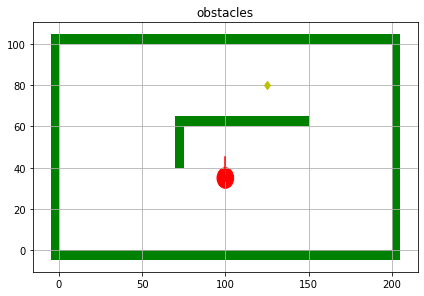

In [2]:
scenario = 1

if scenario==1:
    # [[xmin, ymin, xmax, ymax], ...]
    objects = [[-5, -5, 205, 0],
               [-5, 100, 205, 105],
               [-5, -5, 0, 105], 
               [200, -5, 205, 105],
               [70, 60, 150, 65],
               [70, 40, 75, 60]
               ]
    goal_point = (125, 80)
    spawn_pose = (100, 35, 90/180*np.pi)

elif scenario==2:
    objects = [[-5, -5, 205, 0],
               [-5, 200, 205, 205],
               [-5, -5, 0, 205], 
               [200, -5, 205, 205],
               [70, 130, 150, 135],
               [70, 60, 150, 65],
               [70, 40, 75, 60]
               ]
    goal_point = (125, 180)
    spawn_pose = (100, 35, 90/180*np.pi)

elif scenario==3:
    objects = [[-5, -5, 205, 0],
               [-5, 200, 205, 205],
               [-5, -5, 0, 205], 
               [200, -5, 205, 205],
               [70, 130, 150, 135],
               [70, 60, 150, 65],
               [70, 60, 75, 135],
               [150, 60, 155, 135]
               ]
    goal_point = (125, 100)
    spawn_pose = (100, 35, 90/180*np.pi)
    
else:
    print('Error! Unknown scenario.')


# Create the simulator
simulator = BugSim(objects, goal=goal_point, 
                   sensor_resolution=20/180*np.pi, view_range=50,
                   safety_distance=5)

# Spawn the robot
simulator.spawn(x=spawn_pose[0], y=spawn_pose[1], theta=spawn_pose[2])

# Show
plt.figure()
simulator.drawBoard()
simulator.showRobot()
plt.title('obstacles');

**The BugSim class**

The BugSim class is a simple simulator for a point shaped robot equipped with a laser scanner.

The BugSim class has the following important attributes:
* **x, y, theta**: the 2d position and orientation (in rad) of the robot
* **view_range**: the maximum viewing distance of the sensor.
* **sensor_resolution**: the angular resolution (in rad) of the sensor.
* **safety_distance**: the robot should keep that distance to obstacles. 
* **goal**: the target position on the board
* **history**: all previously visited poses of the robot, general form: [[x0, y0, theta0], [x1, y1, theta1], ... ]

Its most important methods are:
* **spawn(x, y, theta)**: Spawn the robot at initial pose (x, y, theta).
* **getPose()**: Gets the current position and orientation of the robot. Returns: A list of values (x, y, theta) where theta is in rad. <br/><br/> 

* **forward(dist)**: Move robot about dist in forward direction. Please note that the robot will not move after a collision has been detected.
* **turn(dtheta)**: Turn robot about dtheta (rad) in mathematically positive direction
* **getNumMoves()**: Get number of motion steps the robot has done since it has been spawned.  <br/><br/> 

* **getScan()**: Returns the sensor readings as numpy array of Nx2-shape where N is the number of measurements and
    * [:, 0] (first column) returns the relative angle phi (in rad)
    * [:, 1] (second column) returns the distance to the closes obstacle
* **getDistAtPhi(sensor_readings, phi)**: Gives the closest distance measurement to relative direction phi (rad). sensor_readings contains the sensor data. <br/><br/> 

* **checkCollision()**: Returns True iff the robot has collided with an obstacle.
* **drawBoard()**: Draws the board with obstacles and target position.
* **showRobot()**: Plot the robot at it's current location.

Let's begin with your first programming task: Using the sensor readings, draw all lidar scan rays from the robot to the obstacles. If the sensors cannot find an object in a specific direction, use the specifed view range as length for the ray. Your plot should resemble [Fig. 1](#fig_1) above.

In a second figure, plot the observed distance (y-axis) with respect to the view angle phi (x-axis).

**Hints:**
1. Use Matplotlib's ``plt.plot()`` for drawing.
2. The number of sensor scans can be obtained with `sensor_readings.shape[0]`

No collision.


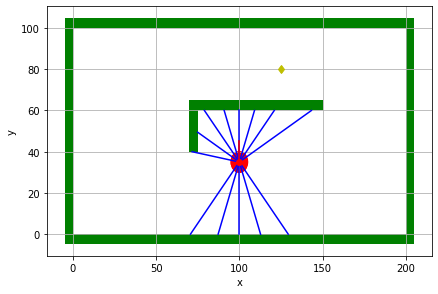

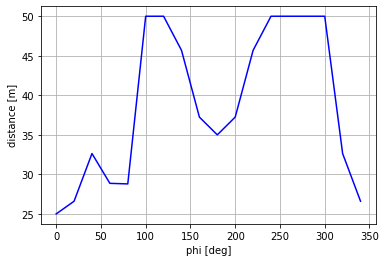

In [5]:
plt.figure()
simulator.drawBoard()
simulator.showRobot()
if simulator.checkCollision():
    print('Collision occured.')
else:
    print('No collision.')

    
# -- TODO: Add your code here for show Lidar scan rays --
sensor_readings = simulator.getScan()
pos = simulator.getPose()
for i in range(sensor_readings.shape[0]):
  x = pos[0] + np.cos(sensor_readings[i,0]+pos[2]) * sensor_readings[i,1]
  y = pos[1] + np.sin(sensor_readings[i,0]+pos[2]) * sensor_readings[i,1]
  plt.plot([pos[0],x],[pos[1],y], 'b')

# -- END TODO --
simulator.showRobot()
plt.xlabel('x')
plt.ylabel('y')


plt.figure()
# -- TODO: Add your code here showing distance vs phi --
plt.plot(180/math.pi * sensor_readings[:,0], 
         np.minimum(sensor_readings[:,1], simulator.view_range), 'b')

plt.xlabel('phi [deg]')
plt.ylabel('distance [m]')
plt.grid(True)

# -- END TODO --

## Exercise 1.2: Moving the robot

The following is not a real exercise, but just an example how to move the robot in simulation. Motion commands are generated at random.

Collision detected!


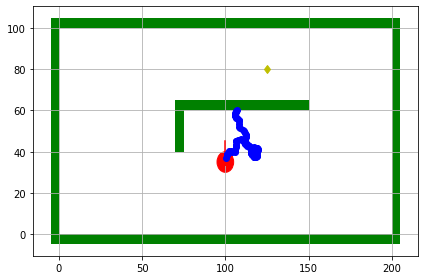

In [6]:
plt.figure()
simulator.drawBoard()
simulator.spawn(x=spawn_pose[0], y=spawn_pose[1], theta=spawn_pose[2])
simulator.showRobot()

for i in range(100):
    simulator.turn(25.0/180.0*np.pi*np.random.randn())
    simulator.forward(2.0*np.random.rand())
    plt.plot(simulator.x, simulator.y, 'bo')
    if simulator.checkCollision():
        break

## Excercise 1.3: Move towards goal

As a preparation for the Bug1 algorithm, write code that drives the robot from the current position towards the goal. The robot should stop once it reaches the goal, an obstacle (within the specified safety distance ``simulator.safety_distance``), or after 1000 movements.

The function ``getTowardsGoalState`` given below may be helpful for this task. 

When moving forward, use a ``stepSize=1``.

In [7]:
def getTowardsGoalState(simulator):
    """Get status of robot when moving towards the goal. 
    
    Args:
        simulator: the simulator class instance
        
    Returns:
        A tuple (goal_dist, toward_goal_phi, toward_goal_free_dist) where
        * goal_dist: distance to goal
        * toward_goal_phi: relative direction towards goal (rad)
        * toward_goal_free_dist: distance to next obstacle in the direction 
            towards the goal (toward_goal_phi)
    """
    gx, gy = simulator.goal
    x, y, theta = simulator.getPose()
    
    goal_dist = np.sqrt((gx-x)**2 + (gy-y)**2)
    
    sensor_readings = simulator.getScan()

    toward_goal_theta = np.arctan2(gy-y, gx-x)
    toward_goal_phi = normalizeAngle(toward_goal_theta-theta)
    toward_goal_free_dist = simulator.getDistAtPhi(sensor_readings, toward_goal_phi)

    return goal_dist, toward_goal_phi, toward_goal_free_dist

def getTowardsObstacleState(simulator):
    """Get status of robot with respect to nearest obstacle. 
    
    Args:
        simulator: the simulator class instance
        
    Returns:
        A tuple (towards_obstacle_phi, towards_obstacle_dist) where
        * towards_obstacle_phi: relative direction towards nearest obstacle (rad)
        * towards_obstacle_dist: distance to nearest obstacle
    """
    sensor_readings = simulator.getScan()

    towards_obstacle_idx = np.argmin(sensor_readings[:,1])
    towards_obstacle_phi = sensor_readings[towards_obstacle_idx, 0]
    towards_obstacle_dist = sensor_readings[towards_obstacle_idx, 1]
    
    return towards_obstacle_phi, towards_obstacle_dist

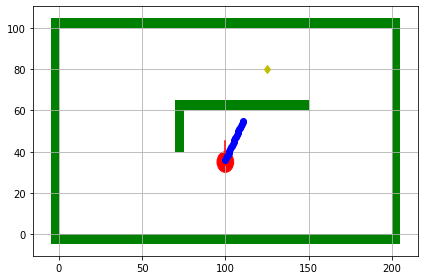

In [8]:
stepSize = 1.0
simulator = BugSim(objects, goal=goal_point, 
                   sensor_resolution=5/180*np.pi, view_range=50,
                   safety_distance=5)
simulator.spawn(x=spawn_pose[0], y=spawn_pose[1], theta=spawn_pose[2])

plt.figure()
simulator.drawBoard()
simulator.showRobot()

# -- TODO: Add your code here --
goal_dist, toward_goal_phi, toward_goal_free_dist = getTowardsGoalState(simulator)
toward_obstacle_phi, toward_obstacle_dist = getTowardsObstacleState(simulator)
    
while (simulator.getNumMoves()<1000) and toward_obstacle_dist > simulator.safety_distance and goal_dist > 0:
  
  simulator.forward(1)
  simulator.turn(toward_goal_phi)
  plt.plot(simulator.x, simulator.y, 'bo')

  goal_dist, toward_goal_phi, toward_goal_free_dist = getTowardsGoalState(simulator)
  toward_obstacle_phi, toward_obstacle_dist = getTowardsObstacleState(simulator)


## Excercise 1.4: Move around obstacle

The second part of preparing Bug1 is circumventing an obstacle at a safety distance specified in ``simulator.safety_distance``. Do so by implementing the closed-loop following as described in the lecture and have the robot do 400 steps. Don't worry about finding a leave point for now.

The robot is initially placed on the border of the obstacle. Please use the same step size as above and make sure that your are using ``scenario=1`` when testing this. Write code both for turning left and right at the obstacle. 

Again, the functions ``getTowardsGoalState`` and ``getTowardsObstacleState`` may be helpful.

400


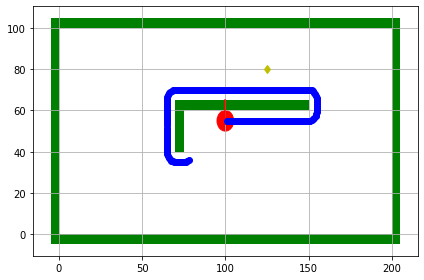

In [15]:
assert scenario==1, 'Please use scenario 1 for this excercise!'

simulator.spawn(x=100, y=55, theta=90/180. * np.pi)

plt.figure()
simulator.drawBoard()
simulator.showRobot()

go_right = False

# -- TODO: Add your code here --
goal_dist, toward_goal_phi, toward_goal_free_dist = getTowardsGoalState(simulator)
toward_obstacle_phi, toward_obstacle_dist = getTowardsObstacleState(simulator)
start = np.asarray(simulator.getPose(),dtype=int)[:2]

while (simulator.getNumMoves()<400) and goal_dist != 0 and (not simulator.checkCollision()):
  D = toward_obstacle_dist
  G = D - simulator.safety_distance
  # delta_G = toward_goal_phi
  T = toward_obstacle_phi+np.pi/2

  simulator.turn(T-np.arctan2(G,1))
  simulator.forward(1)

  # np.asarray(simulator.history)
  goal_dist, toward_goal_phi, toward_goal_free_dist = getTowardsGoalState(simulator)
  toward_obstacle_phi, toward_obstacle_dist = getTowardsObstacleState(simulator)
  
  plt.plot(simulator.x, simulator.y, 'bo')

print(simulator.getNumMoves())

    

## Excercise 1.5: Putting everything together

Now, write the full Bug1 algorithm as described in the lecture slides.

**Hints**: 
1. First, implement the two functions ``moveTowardsGoal`` and ``moveAroundObstacle``  based on the previous excercises.  
2. You may select a fixed direction (left or right) when returning to the best leave point. Choosing the shortest distance to the leave point may be omitted for simplicity.
3. When checking if a leave point or safety distance to obstacle is reached, keep in mind that the robot may not hit leave points or safety distances to obstacles perfectly accurate.

Goal was reached.
Terminated after step:  712


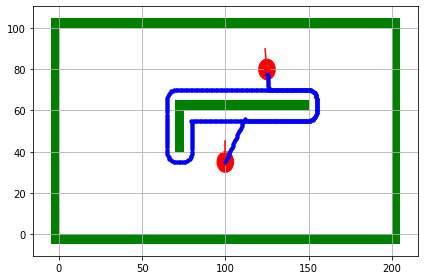

In [20]:
stepSize = 1.0
maxMoves = 3000

simulator = BugSim(objects, goal=goal_point, 
                   sensor_resolution=5/180*np.pi, view_range=50,
                   safety_distance=5)
simulator.spawn(x=spawn_pose[0], y=spawn_pose[1], theta=spawn_pose[2])

plt.figure()
simulator.drawBoard()
simulator.showRobot()

def moveTowardsGoal(simulator, stepSize, maxTotalMoves=1000):
    """Move in a straigt line towards the goal.
    
    This will move the robot towards the obstacle until the goal is reached,  
    an obstacle is encountered within the safety distance, or the maximum 
    number of steps has been exceeded.
    
    Args:
        simulator: the simulator object
        stepSize: the distance to move in each forward step
        maxTotalMoves: stop execution after maxTotalMoves
        
    Returns:
        True if the goal has been reached, False otherwise.
    """
    # -- TODO: Add your code here --
    goal_dist, toward_goal_phi, toward_goal_free_dist = getTowardsGoalState(simulator)
    while simulator.getNumMoves()<maxTotalMoves and toward_goal_free_dist >= simulator.safety_distance and goal_dist >= stepSize:
        simulator.turn(toward_goal_phi)
        simulator.forward(stepSize)
        goal_dist, toward_goal_phi, toward_goal_free_dist = getTowardsGoalState(simulator)

    return True if goal_dist <= stepSize else False


def moveAroundObstacle(simulator, stepSize, targetPos, 
                       go_right=False, maxTotalMoves=1000):
    """Circumvent an obstacle.
    
    This will move the robot towards the obstacle until the goal 
    is reached, the robot arrives close to a given target position, 
    or the maximum number of steps has been exceeded.
    
    Args:
        simulator: the simulator object
        stepSize: the distance to move in each forward step
        targetPos: the target position at the border of the obstacle
            (e.g. the hit point or the leave point)
        go_right: True if robot should go right at obstacle   
        maxTotalMoves: stop execution after maxTotalMoves
        
    Returns:
        True if the goal has been reached, False otherwise.
    """
    # -- TODO: Add your code here --
    
    goal_dist, toward_goal_phi, toward_goal_free_dist = getTowardsGoalState(simulator)
    toward_obstacle_phi, toward_obstacle_dist = getTowardsObstacleState(simulator)
    
    leave_point = (simulator.x, simulator.y)
    min_dist_to_goal = goal_dist

    step_size_sq = (1.5*stepSize)**2
    target_dist_sq = (simulator.x-targetPos[0])**2 + (simulator.y-targetPos[1])**2
    old_target_dist_sq = target_dist_sq

    while simulator.getNumMoves()<maxTotalMoves and goal_dist >= stepSize and \
    (not simulator.checkCollision()) and ((target_dist_sq > step_size_sq) or (old_target_dist_sq <= step_size_sq)):
        D = toward_obstacle_dist
        G = D - simulator.safety_distance
        if go_right:
            T = toward_obstacle_phi - np.pi/2
            Turn = T+np.tan(G)
        else:
            T = toward_obstacle_phi + np.pi/2
            Turn = T-np.tan(G)

        simulator.turn(Turn)
        simulator.forward(stepSize)

        goal_dist, toward_goal_phi, toward_goal_free_dist = getTowardsGoalState(simulator)
        toward_obstacle_phi, toward_obstacle_dist = getTowardsObstacleState(simulator)
        old_target_dist_sq = target_dist_sq
        target_dist_sq = (simulator.x-targetPos[0])**2 + (simulator.y-targetPos[1])**2

        if goal_dist < min_dist_to_goal:
            leave_point = (simulator.x, simulator.y)
            min_dist_to_goal = goal_dist
        
    return (True, None) if goal_dist <= stepSize else (False, leave_point) 
    
goal_dist, _, _ = getTowardsGoalState(simulator)
reached_goal = goal_dist <= stepSize

# -- TODO: Add your code here --
while (not reached_goal) and (simulator.getNumMoves()<maxMoves) and (not simulator.checkCollision()):
    reached_goal = moveTowardsGoal(simulator,1)
    #print(np.asarray(simulator.getPose()[:-1],dtype=int))
    if reached_goal:
        break
    reached_goal, leave_point = moveAroundObstacle(simulator,1, (simulator.x, simulator.y))
    #print(np.asarray(simulator.getPose()[:-1],dtype=int))
    if reached_goal:
        break
    reached_goal, _ = moveAroundObstacle(simulator,1,leave_point, go_right=True)

if reached_goal:
    print('Goal was reached.')
else: 
    print('Goal cannot be reached.')
print('Terminated after step: ', simulator.getNumMoves())
history = np.asarray(simulator.history)
plt.plot(history[:,0], history[:,1], 'b.')
simulator.showRobot()

If you were able to solve the task, you may use the next section to create an anmiation of your robot:

In [ ]:
anim = simulator.animate(skipFrames=2)
rc('animation', html='jshtml')
anim

## Optional excercises

* Create your own scenarios and test the algorithm.
* Write code for Bug2 or Tangent Bug.